# Clustering Analysis of Samples
This notebook takes in TPM values and generate clusterplot and PCA plot check for batch effect and data reproducibility.

It is used and shared as part of the publication:

    Characterization of CA-MRSA TCH1516 exposed to Nafcillin in 
    Bacteriological and Physiological Media

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as hc
import scipy.spatial as sp
%matplotlib inline

<Figure size 432x288 with 0 Axes>

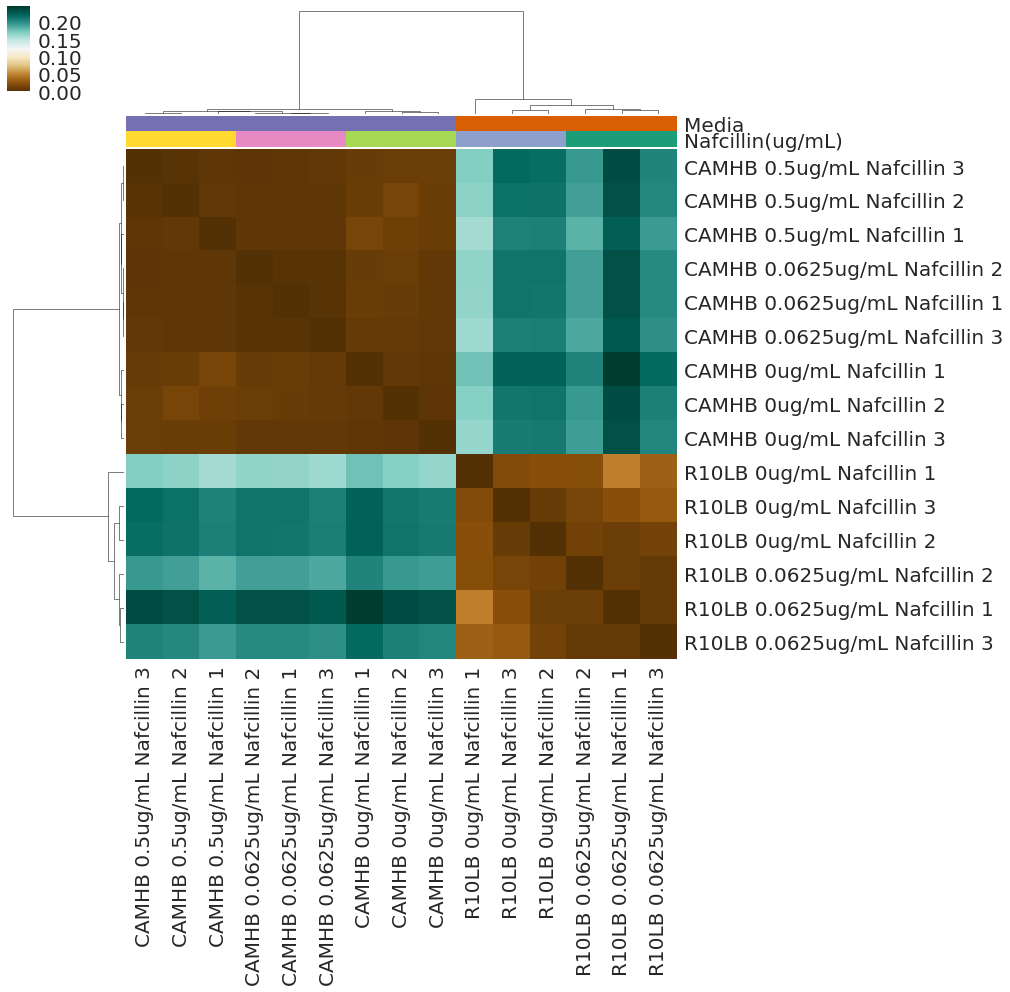

In [56]:
plt.clf()
combat_tpm = pd.read_csv('combat_tpm.csv',index_col=0)

#drop because it is too similar to 0.0625
combat_tpm.drop([i for i in combat_tpm.columns if '0.031' in i], axis=1, inplace=True)

# assign colors to media and antibiotic conc.
condition = list(set(x[:-2] for x in combat_tpm.columns))
condition.extend(['R10LB', 'CAMHB'])
colors = (list(plt.cm.Set2(np.arange(2,6))))
colors.extend(list(plt.cm.Dark2(np.arange(0,5))))
uniq_col = dict(zip(condition, colors))


row_col = pd.DataFrame(index=combat_tpm.columns)
col_dict = {}
for i in combat_tpm.columns:
    media = i.split(' ')[0]
    naf = i[:-2]
    col_dict.update({i:[uniq_col[media], uniq_col[naf]]})
row_col = pd.DataFrame(col_dict).T
row_col = row_col.rename(columns={0:'Media',
                       1: 'Nafcillin(ug/mL)'})

#calculate spearman 
It is used and shared as part of the publication:

    Characterization of CA-MRSA TCH1516 exposed to Nafcillin in 
    Bacteriological and Physiological Mediacorrelation and distance
corr = combat_tpm.corr(method='spearman')
DF_dism = 1 - corr
linkage = hc.linkage(sp.distance.squareform(DF_dism),
                     method='average', metric='cosine')

sns.set(font_scale=2, font='DejaVu Sans')

#draw the clustermap
cg = sns.clustermap(DF_dism,
                    row_linkage=linkage,
                    col_linkage=linkage,
                    col_colors=row_col,
                    cmap='BrBG',
                    figsize=(12,12))

# PCA Analysis
Run PCA Analysis to check for clustering of samples vs. batches

In [41]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from matplotlib.legend import Legend

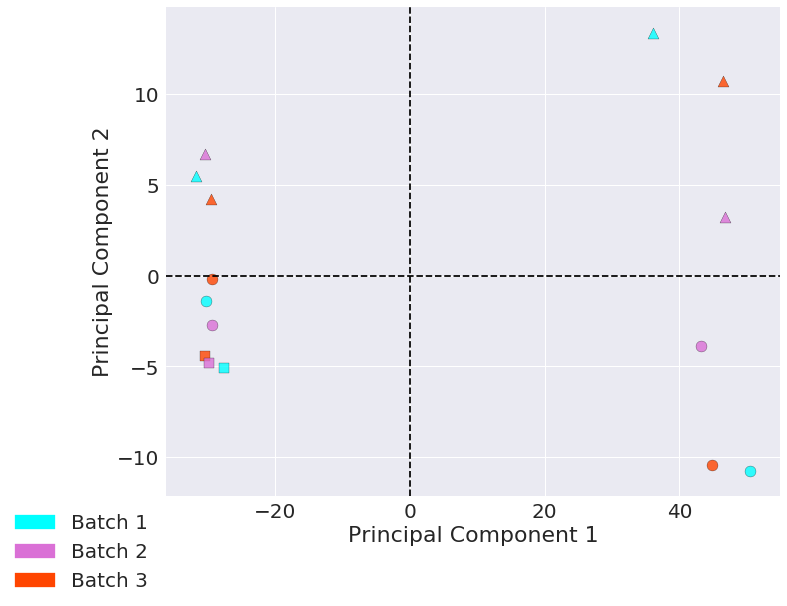

In [57]:
pca = PCA()
pca = PCA()
DF_weights =  pd.DataFrame(pca.fit_transform(combat_tpm.dropna().T), index=combat_tpm.dropna().columns)

#### generate color and shape dictionary for plotting
for s in DF_weights.index.values:
    split = s.split(' ')
    DF_weights.loc[s,'Batch'] = split[-1]
    DF_weights.loc[s,'Media'] = split[0]
    DF_weights.loc[s,'Naf'] = split[1]
color = dict(zip(DF_weights['Batch'].unique(),
                 ['aqua', 'orchid', 'orangered']))
shapes = dict(zip(DF_weights['Naf'].unique(), 
                 ['o', 's', '^']))

#plot PC1 and PC2
fig,ax = plt.subplots(figsize=(11,9))
ax.grid(True)
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')
for idx, sample in DF_weights.iterrows():
    batch = idx.split(' ')[-1]
    media = idx.split(' ')[1]
    ax.scatter(sample[0],sample[1],alpha=0.8, c=color[batch],
               edgecolors='k', s=120, marker=shapes[media])

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

#custom legend for batches
col_legend = []
for i in color:
    col_legend.append(mpatches.Patch(color=color[i], label='Batch ' + i))
col_legend[2], col_legend[1] = col_legend[1], col_legend[2] #rearrange in batch order
plt.legend(handles=col_legend, bbox_to_anchor=(0,0))

##### The samples do not cluster by batch